# Identify 15 most valuable players for next season
---
### Goal

Which players should we sign and play next season? Answering this question is non-trivial, unsupervised and involves extensive analysis. 

To answer this question I use the CSV “all_batters.csv”, which contains a data set of seasonal stat lines: plate appearances, walks, strikeouts and home runs for a given player `player_id_hash`. Based on this data, I then identify the 15 most valuable players for next season, assuming all players will have 400 plate appearances next season. Then I rank those players and quantify my level of confidence.  


### Data Overview
- `player_id_hash`: player id
- `pa`: number of plate appearances
- `bb`: number of walks
- `so`: number of strikeouts
- `hr`: number of home runs

### Table of Contents
> #### Part 0. [Imports](#imports)
> #### Part 1. [Preliminary data analysis](#prelim)
> #### Part 2. [Dealing with the large range in `pa`](#range_pa)
> #### Part 3. [Normalize stats for `pa`](#normalize_pa)
> #### Part 4. [Group players into clusters](#cluster)
> #### Part 5. [Consider other features](#oth_features)
> #### Part 6. [Identify top 15 players](#top15)
> #### Part 7. [Quantifying confidence in our top 15](#ci)
> #### Part 8. [Summarize results](#summarize)
> #### Part 9. [Just for fun! (monte carlo simulation)](#simulate)
---

<a id="imports"></a>
## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
from sklearn.cluster import KMeans
from random import *
from pathlib import Path
import os

%matplotlib inline
sns.set(font_scale=1.2)

# If plots don't work, set up free plotly account and enter info... https://plot.ly/#/
# plotly.tools.set_credentials_file(username='ENTER_USERNAME', api_key='ENTER_KEY')

<a id="prelim"></a>
## Preliminary Data Analysis

In [2]:
# Import csv data as dataframe
df = pd.read_csv('all_batting.csv')

# Get summary of data
df.describe()

,pa,bb,so,hr
count,2102.000000,2102.000000,2102.000000,2102.000000
mean,250.596575,25.018078,55.959562,7.887726
std,130.799136,18.904169,35.005810,8.643709
min,3.000000,0.000000,0.000000,0.000000
25%,147.000000,11.000000,29.000000,2.000000
50%,250.000000,20.000000,51.000000,4.000000
75%,350.750000,35.000000,78.000000,12.000000
max,613.000000,100.000000,174.000000,49.000000


In [3]:
# Check for null values
print("Number of null values:\n")
print(df.isna().sum())

# Check for number of unique players
print("Number of unique players: ", df['player_id_hash'].unique().size)
num_seasons = df.groupby('player_id_hash').size().to_frame().rename(columns={0: 'No. seasons'})
num_seasons.sort_values(by='No. seasons', ascending=False).head()

Number of null values:

player_id_hash    0
pa                0
bb                0
so                0
hr                0
dtype: int64
Number of unique players:  984


,No. seasons
player_id_hash,
aba3b6fd5d186d28e06ff97135cade7f,9
17d63b1625c816c22647a73e1482372b,8
2bb232c0b13c774965ef8558f0fbd615,8
f64eac11f2cd8f0efa196f8ad173178e,7
f33ba15effa5c10e873bf3842afb46a6,7


We can see that many players have 2+ seasons of data and one player has 9 total seasons! Since our goal is to compare players, let's create a new df that aggregates stats by player. Let's also add a column `No. seasons` to keep track of our original info.

In [4]:
# Aggregate by player and add new column
df_player = df.groupby('player_id_hash').sum()
df_player = df_player.join(num_seasons, on='player_id_hash')
df_player = df_player[['No. seasons', 'pa', 'bb', 'so', 'hr']]

# Summary stats for our new df
df_player.describe()

,No. seasons,pa,bb,so,hr
count,984.000000,984.000000,984.000000,984.000000,984.000000
mean,2.136179,535.319106,53.443089,119.539634,16.849593
std,1.240119,391.978242,48.243415,97.137947,20.758450
min,1.000000,7.000000,0.000000,0.000000,0.000000
25%,1.000000,248.000000,19.000000,49.000000,4.000000
50%,2.000000,427.500000,40.000000,93.000000,9.000000
75%,3.000000,732.000000,73.000000,166.000000,22.000000
max,9.000000,2288.000000,349.000000,613.000000,144.000000


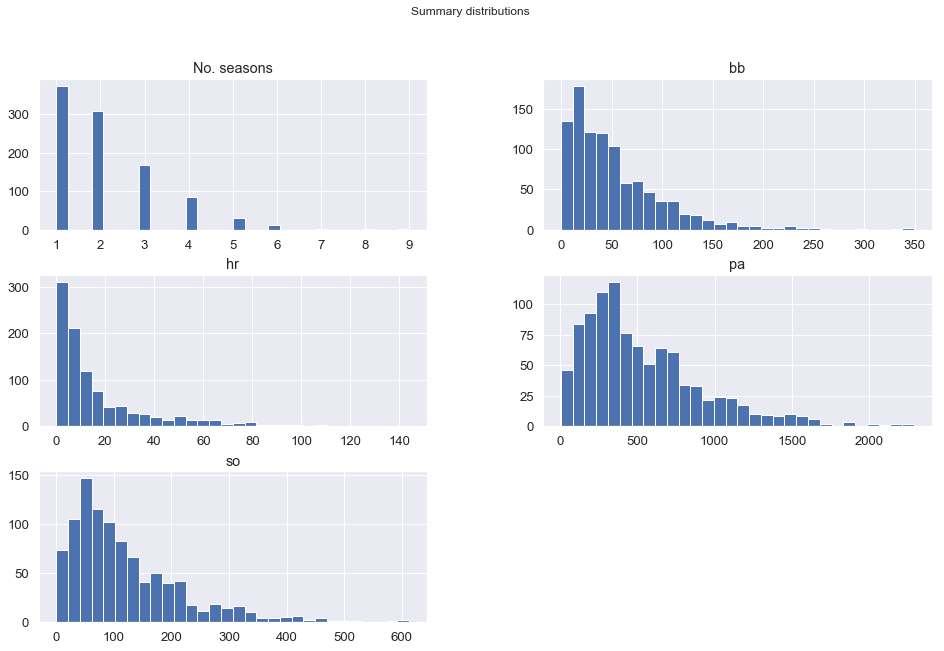

In [5]:
# Plot distributions
df_player.hist(figsize=(16,10), bins=30);
plt.suptitle('Summary distributions');

__Findings:__
* All graphs are heavily right skewed.
* Very few people have played more than 4 seasons, with the majority playing only 1 season.
* Many people have between 0-150 `so` and between 0-50 `bb`.
* `pa` has the most normal looking distribution, with a peak around 300-400.
* `hr` has an explonential distribution.
* It looks like `so`, `pa`, and `bb` might have log-normal distributions...let's investigate further by doing a log-transformation on these stats.

C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



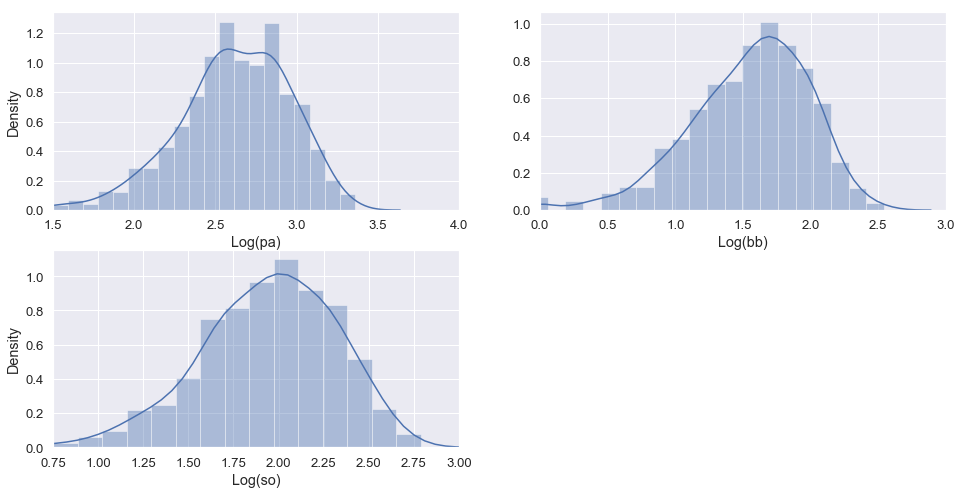

In [6]:
# Plotting the log-transform of bb and pa
plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
sns.distplot(np.log10(df_player['pa'] + .0001))
plt.xlim([1.5, 4])
plt.xlabel('Log(pa)')
plt.ylabel('Density')

plt.subplot(2,2,2)
sns.distplot(np.log10(df_player['bb'] + .0001))
plt.xlim([0, 3])
plt.xlabel('Log(bb)')

plt.subplot(2,2,3)
sns.distplot(np.log10(df_player['so'] + .0001))
plt.xlim([0.75, 3])
plt.xlabel('Log(so)')
plt.ylabel('Density')
plt.show()

__Findings:__ `log(so)`, `log(pa)` and `log(bb)` all have a normal distribution.

<a id="range_pa"></a>
## Dealing with the large range in `pa`

An important factor to consider is the number of PA, which varies from 7 to 2288. This is a big difference and will impact our determination of the "most valuable" players. 

Why is this range so big? There are several reasons that may lead to variations in PA. Thus PA might actually be an indicator for player value.
* Injuries - Players with more injuries are less likely to be playing. The likelihood a player will get injured is an important factor in their value. However since we are assuming each player will have 400 PA, let's assume they won't get injured.
* Batting order - Players receive different number of PA based on where they are in the lineup. A player's order in the lineup may dictate their value. 
* Experience - Some players have been playing for longer than others. A player who has been in the MLB for many years has been good enough to remain in the MLB. Also, it's easier to predict their performance in upcoming seasons because there's  more data on their performance history. 
* Age - Younger players will likely have fewer PA because they've been in the MLB fewer years. A 20-year old rookie phenom will have less PA than a veteran, even if they are far better.

One thing that would be useful in this analysis is temporal info about the data. If a player has played in 3 seasons with 400, 200, 50 PA respectively, the order of these seasons is useful. [400, 200, 50] might indicate that the player's value is decreasing, while [50, 200, 400] might indicate their value is increasing. It would be better to use other stats (e.g. HR, BB) to more directly infer their trend in performance. But again, but we don't know the order. We can only look at how a player's stats change from year-to-year, but we can't make any assumptions about a trend.

Keeping in mind that players will have 400 PA in the next season, it's important to consider the number of PA in the dataset. Ultimately, it's not equivalent to compare a player with 10 PA to a player with 1000 PA, even if stats are normalized by PA. In other words, Player A with 1 HR in 10 PA (10% HR rate) is not necessarily better than Player B with 80 HR in 1000 PA (8% HR rate). In fact, I would rather select Player B because Player A's stats are more uncertain and could be due to random chance. To reduce this uncertainty, we can filter the data using a variety of techniques.
* by total PA (e.g. include players with 300+ total PA) `df_player[df_player['pa'] >= 300]`
* by percentile (e.g. include players within the 10th percentile w.r.t. PA) `df_player[['pa']].quantile(q=0.25)`
* by PA per season (e.g. include players with 100+ PA per season) `df_player[(df_player['pa']/df_player['No. seasons']) >= 100]`
* by standard deviation (e.g. include players with a lower bound inside 1 StDev of the mean PA)

For this analysis, players with less than 1 standard deviation from the mean will be excluded.

In [7]:
print("Number of players in original dataset: ", len(df_player))
# Filter by standard deviation
df_player = df_player[(df_player['pa']) >= 
                      (df_player['pa'].mean() - df_player['pa'].std())]

# Find number of players in filtered dataset
print("Number of players in filtered dataset: ", len(df_player))

Number of players in original dataset:  984
Number of players in filtered dataset:  875


<a id="normalize_pa"></a>
## Normalize stats for `pa`
We need to normalize our data for `pa` so we can evaluate players consistently because a player will have more `bb`, `so`, `hr` if they have more `pa`.

In [8]:
# Add normalized features
df_player['other'] = df_player['pa'] - df_player['bb'] - df_player['hr'] - df_player['so']
df_player['bb/pa'] = df_player['bb'] / df_player['pa']
df_player['so/pa'] = df_player['so'] / df_player['pa']
df_player['hr/pa'] = df_player['hr'] / df_player['pa']
df_player['oth/pa'] = df_player['other'] / df_player['pa']
df_player.head()

,No. seasons,pa,bb,so,hr,other,bb/pa,so/pa,hr/pa,oth/pa
player_id_hash,,,,,,,,,,
00ac8ed3b4327bdd4ebbebcb2ba10a00,2,230,14,35,2,179,0.060870,0.152174,0.008696,0.778261
00e26af6ac3b1c1c49d7c3d79c60d000,1,159,32,39,10,78,0.201258,0.245283,0.062893,0.490566
01386bd6d8e091c2ab4c7c7de644d37b,3,369,63,112,6,188,0.170732,0.303523,0.016260,0.509485
013a006f03dbc5392effeb8f18fda755,2,827,130,138,12,547,0.157195,0.166868,0.014510,0.661427
019d385eb67632a7e958e23f24bd07d7,4,1343,208,373,13,749,0.154877,0.277736,0.009680,0.557707


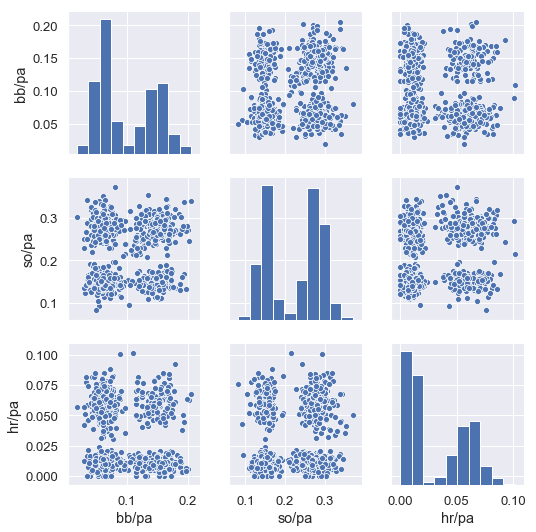

In [9]:
# Let's plot our normalized stats
sns.pairplot(df_player[['bb/pa', 'so/pa', 'hr/pa']])
plt.show()

__Findings:__ Interesting...Now that's we've normalized by `pa` the stats are bimodal and less skewed. Also, looking at the `bb/pa`, `bb/so` and `hr/so`, there are multiple (possibly 4?) distinct groups! Let's group the data into four clusters, then visualize in an interactive 3-D scatter plot. Keep in mind that the most valuable players will have high `bb/pa` and `hr/pa` and with low `so/pa`. 

<a id="cluster"></a>
## Group players into clusters
Let's utilize `sklearn`'s off-the-shelf `Kmeans` algorithm to cluster the players. Let's also use `plotly` to create an interactive 3D figure.

In [10]:
from utils import Interactive3dPlot

data = df_player[['bb/pa', 'so/pa', 'hr/pa']].copy()
p = Interactive3dPlot(data=data, num_clusters=4)
p.plot()

C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



__Findings:__ Looking at the graph above it actually looks like there are 8 clusters. Again, the most valuable players will have high `hr/pa` and `bb/pa` and low `so/pa`, so let's take a closer look at those players. It appears players in trace 0 are who we are looking for. Let's isolate this cluster and break it down into more clusters, and plot.

Note: We can double-click trace on the legend above to zoom in on this group. 

In [11]:
data_tr0 = p.get_data(trace=0)
p2 = Interactive3dPlot(data=data_tr0, num_clusters=4)
p2.plot()

C:\Users\natek\Desktop\Personal\job_apps\interviews\SF_Giants\utils.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [12]:
# See how many players are left
print("Players in this trace: ", len(data_tr0))
print("Avg. players per cluster: ", len(data_tr0)/4)

Players in this trace:  131
Avg. players per cluster:  32.75


__Findings:__ We've now narrowed it down to less than 150 players. It actually looks like one cluster has significantly more homeruns than the others. Of the other 3 clusters, one of them has less strikeouts and more walks. But which players are the most valuable? Is a player with 10 `hr` and 15 `so` better than a player with 2 `hr` and 2 `so`? Ultimately, we need to place a value on each statistic.

__My prediction is that the top 15 players will come from the orange (trace 0) cluster!__

To help answer these questions, let's add some more features.

<a id="oth_features"></a>
## Consider other features
So far, we have data on `pa`, `bb`, `hr`, `so`, `No. seasons`.
That's a good start, but let's consider others.

First, let's add `w_sum` which is a weighted sum of the metrics. We will draw some inspiration from SLG and multiply `hr` by 4. We will then sum the weighted `hr` with `bb` and subtract `so`, and finally normalize by `pa` as before.

`w_sum` $ = \dfrac{4* \text{homeruns} + \text{walks} - \text{strikeouts}}{\text{plate appearances}} $

I like this stat because it makes use of all the data points we have. However, we made a big assumption when using `w_sum`, that `bb` and `so` are weighted equality (1 and -1, respectively) and `hr` is 4x as important. While I think this is reasonable let's make it a bit more robust by creating two additional metrics, `w_sum2` and `w_sum3` to see how players' stats are impacted by the weights

where,

`w_sum2` $ = \dfrac{2*homeruns + walks - strikeouts}{plate \ appearances} $

`w_sum3` $ = \dfrac{4*homeruns + walks - 2*strikeouts}{plate \ appearances} $

Let's also add `bb/so` and `hr/so`. `bb/so` is commonly used in baseball, and I think `hr/so` will give us good information as well.

In [13]:
df_player['w_sum'] = (df_player['bb'] + 4*df_player['hr'] - 
                         df_player['so']) / df_player['pa']

df_player['w_sum2'] = (df_player['bb'] + 2*df_player['hr'] - 
                         df_player['so']) / df_player['pa']

df_player['w_sum3'] = (df_player['bb'] + 4*df_player['hr'] - 
                         2*df_player['so']) / df_player['pa']

df_player['bb/so'] = df_player['bb'] / df_player['so']
df_player['hr/so'] = df_player['hr'] / df_player['so']

We should also make use of our __seasonal data__. It's useful to know how much a player's stats fluctuate from season to season. We'd prefer a player to have more consistent stats so we can more confidently predict the future. Let's use standard deviation so the units remain the same (and we can interpret results directly). 

To do this, we will use the original `df` which includes the disaggregated data. Like before, let's normalize data by plate appearance and then recreate the features we just added above.

In [14]:
df['other'] = df['pa'] - df['bb'] - df['hr'] - df['so']
df['bb/pa'] = df['bb'] / df['pa']
df['so/pa'] = df['so'] / df['pa']
df['hr/pa'] = df['hr'] / df['pa']
df['oth/pa'] = df['other'] / df['pa']
df['w_sum'] = (df['bb'] + 4*df['hr'] - df['so']) / df['pa']
df['w_sum2'] = (df['bb'] + 2*df['hr'] - df['so']) / df['pa']
df['w_sum3'] = (df['bb'] + 4*df['hr'] - 2*df['so']) / df['pa']
df['bb/so'] = df['bb'] / df['so']
df['hr/so'] = df['hr'] / df['so']

Now, let's take the standard deviation of the metrics and append it to `df_player` so we can see how much stats fluctuate per season (for players with 2+ seasons). Players with only 1 season have `NaN` values. To adjust this, I'm going to fill them with the median values. There are other techniques to fill these values, so feel free to change it.

Now, not only do we have all the stats, but we also have some idea about how much a player's stats fluctuate from season to season. As mentioned before, we don't have temporal data, so we cannot make any assumptions about whether a player's performance is improving (or not) each subsequent season.

In [15]:
# Get standard deviation of all metrics
temp_df = df.groupby('player_id_hash').std()
temp_df = temp_df[['bb/pa', 'so/pa', 'hr/pa', 'oth/pa', 'w_sum', 'w_sum2', 'w_sum3', 'bb/so', 'hr/so']]
temp_df = temp_df.rename(columns={'bb/pa':'STD_bb/pa', 'so/pa':'STD_so/pa', 'hr/pa':'STD_hr/pa', 
                                'oth/pa':'STD_oth/pa', 'w_sum':'STD_w_sum', 'w_sum2': 'STD_w_sum2',
                                'w_sum3':'STD_w_sum3',  'bb/so':'STD_bb/so', 'hr/so':'STD_hr/so'})
df_player = df_player.join(temp_df)

# Fill in median for NaN
df_player = df_player.fillna(df_player.median())

# Summary stats for our new df
df_player.describe()

,No. seasons,pa,bb,so,hr,other,bb/pa,so/pa,hr/pa,oth/pa,...,hr/so,STD_bb/pa,STD_so/pa,STD_hr/pa,STD_oth/pa,STD_w_sum,STD_w_sum2,STD_w_sum3,STD_bb/so,STD_hr/so
count,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,...,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000
mean,2.264000,591.517714,59.123429,132.118857,18.593143,381.682286,0.099758,0.223457,0.031694,0.645091,...,0.151972,0.022485,0.026801,0.009316,0.038508,0.055870,0.041441,0.072805,0.129801,0.050332
std,1.251094,379.541164,48.182299,95.748775,21.350865,254.308399,0.046202,0.067678,0.026317,0.091481,...,0.141195,0.017892,0.022818,0.008393,0.031111,0.042492,0.031874,0.057817,0.149320,0.066998
min,1.000000,144.000000,3.000000,13.000000,0.000000,78.000000,0.018868,0.082278,0.000000,0.387097,...,0.000000,0.000047,0.000016,0.000000,0.000044,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,308.500000,25.000000,62.000000,4.000000,192.000000,0.059586,0.151890,0.008929,0.572527,...,0.042553,0.013686,0.016304,0.005182,0.024014,0.035119,0.025897,0.044197,0.070797,0.024788
50%,2.000000,483.000000,46.000000,104.000000,10.000000,298.000000,0.076832,0.252294,0.015411,0.635667,...,0.083333,0.018250,0.021892,0.007087,0.032277,0.048466,0.035674,0.061176,0.096200,0.034764
75%,3.000000,760.000000,79.000000,176.500000,24.000000,494.000000,0.145751,0.281543,0.058201,0.726624,...,0.233259,0.025122,0.029471,0.009560,0.041814,0.063366,0.048021,0.086733,0.129944,0.051054
max,9.000000,2288.000000,349.000000,613.000000,144.000000,1654.000000,0.205279,0.371859,0.101266,0.829235,...,0.923077,0.136760,0.220784,0.082465,0.346094,0.465694,0.370315,0.652251,1.873833,0.999703


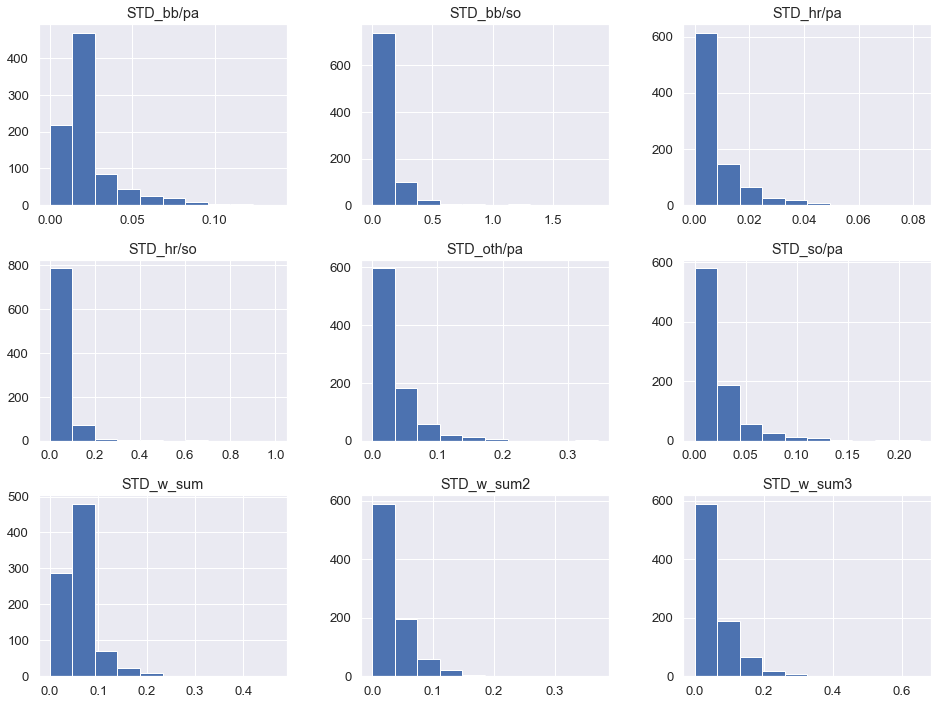

In [16]:
# Let's see the distribution for these
df_player[['STD_bb/pa', 'STD_so/pa', 'STD_hr/pa', 'STD_oth/pa', 
           'STD_w_sum', 'STD_w_sum2', 'STD_w_sum3', 'STD_bb/so', 
           'STD_hr/so']].hist(figsize=(16,12));

__Findings:__ All distributions are heavily right skewed, indicating the majority of players have a small standard deviation. Remember, that we filled in the median values for all 900+ players that only played one season, so the graphs are are a bit misleading due to that.

<a id="top15"></a>
## Identify top 15 players

Okay, now we've got a lot of metrics to consider. How can we use these to find the top 15 players?

The most important statistics in my opinion are `w_sum`, `w_sum2`, `w_sum3`, `bb/so`, `hr/so`. While I think the `STD_` metrics are interesting and provide additional info, I'm going to simplify things and focus on other stats.

It would help if we ranked them with 1 being the best, 2 being the second best, and so on.

### Rank players

In [17]:
# Include ranks for averages
stats = ['hr/pa', 'bb/pa', 'so/pa', 'w_sum', 
             'w_sum2', 'w_sum3', 'bb/so', 'hr/so']
for stat in stats:
    if stat == 'so/pa':
        ascending=True
    else:
        ascending=False
    df_player['Rank_'+ stat] = df_player[stat].rank(method='min', ascending=ascending)

I think it's fair to give each of the five stats an equal weight, so I'm going to create one additional stat, `Rank_Total`, that's calculated by summing the ranks of the five stats.

`Rank_Total` = `Rank_w_sum` + `Rank_w_sum2` + `Rank_w_sum3` + `Rank_bb/so` + `Rank_hr/so`.

Finally, lets sort for the top 15 by `Rank_Total`.

In [18]:
df_player['Rank_TOTAL'] = df_player[['Rank_w_sum', 'Rank_w_sum2', 
                             'Rank_w_sum3', 'Rank_bb/so', 'Rank_hr/so']].sum(axis=1)

top15 = df_player.sort_values('Rank_TOTAL', ascending=True).head(15)

top15[['Rank_TOTAL','Rank_w_sum', 'Rank_w_sum2', 'Rank_w_sum3', 'Rank_bb/so', 'Rank_hr/so']]

,Rank_TOTAL,Rank_w_sum,Rank_w_sum2,Rank_w_sum3,Rank_bb/so,Rank_hr/so
player_id_hash,,,,,,
ebd6d2f5d60ff9afaeda1a81fc53e2d0,24.0,1.0,1.0,1.0,16.0,5.0
297fa7777981f402dbba17e9f29e292d,29.0,3.0,3.0,3.0,11.0,9.0
109d2dd3608f669ca17920c511c2a41e,50.0,2.0,2.0,4.0,24.0,18.0
42d6c7d61481d1c21bd1635f59edae05,52.0,7.0,4.0,5.0,12.0,24.0
0c9ebb2ded806d7ffda75cd0b95eb70c,66.0,10.0,7.0,7.0,16.0,26.0
1cd3882394520876dc88d1472aa2a93f,70.0,9.0,5.0,6.0,5.0,45.0
cfa5301358b9fcbe7aa45b1ceea088c6,88.0,12.0,6.0,11.0,9.0,50.0
ebb71045453f38676c40deb9864f811d,111.0,31.0,15.0,16.0,14.0,35.0
e9fd7c2c6623306db59b6aef5c0d5cac,112.0,13.0,10.0,9.0,70.0,10.0


Before, we zoomed into 34 select players in the 3D graph that we hypothesized were valuable. As a sanity check, let's see how many of the players in `top15` were also in that set of 34.

In [19]:
in_top = [x for x in top15.index.values if (x in data_tr0.index.values)]
not_in_top = [x for x in top15.index.values if (x not in data_tr0.index.values)]
print(f"{len(in_top)} of players in `top15` were also in our 3D graph.")

15 of players in `top15` were also in our 3D graph.


Wonderful! __All 15 players were also in our zoomed 3D graph.__ Now I feel relevatively confident in our top 15.

<a id="ci"></a>
## Quantifying confidence in our top 15
Now that we've selected the 15 most valuable players, let's see how confident we are in this. To achieve this, let's do the following:
1. Find the "worst" (i.e. least impressive) scores amongst `top15` for _each_ of `w_sum`, `w_sum2`, `w_sum3`, `bb/so`, `hr/so`
2. Calculate _population_ mean and standard deviation for these scores (do log-transformations to make distributions normal)
3. Plot distributions
3. See if stats for `top15` fall outside standard deviation of the mean. How many standard deviations? 

#### Step 1 - calculate min scores for each metric across all players in `top15`

In [20]:
min_stats = top15.loc[:, ['w_sum', 'w_sum2', 'w_sum3']].min().values
min_stats = np.append(min_stats, np.log10(top15.loc[:, 'bb/so'].values).min())
min_stats = np.append(min_stats, np.log10(top15.loc[:, 'hr/so'].values).min())
print("Minimum stats for top 15")
print(min_stats)

Minimum stats for top 15
[ 0.23225806  0.12429379  0.12004662 -0.07106336 -0.3651475 ]


#### Step 2 - find $\mu$ and $\sigma$ for each statistic

In [21]:
sigma = df_player[['w_sum', 'w_sum2', 'w_sum3']].std().values
sigma = np.append(sigma, np.log10(df_player[['bb/so', 'hr/so']] + 10**-5).std())
X = df_player[['w_sum', 'w_sum2', 'w_sum3']].mean().values
X = np.append(X, np.log10(df_player[['bb/so', 'hr/so']] + 10**-5).mean())

print("Population standard deviation")
print(sigma)
print("\nPopulation mean")
print(X)

Population standard deviation
[0.11594746 0.08294837 0.15611576 0.23731095 0.72362855]

Population mean
[ 0.00307527 -0.06031225 -0.22038223 -0.37724515 -1.09020447]


#### Step 3 - plot distributions

C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



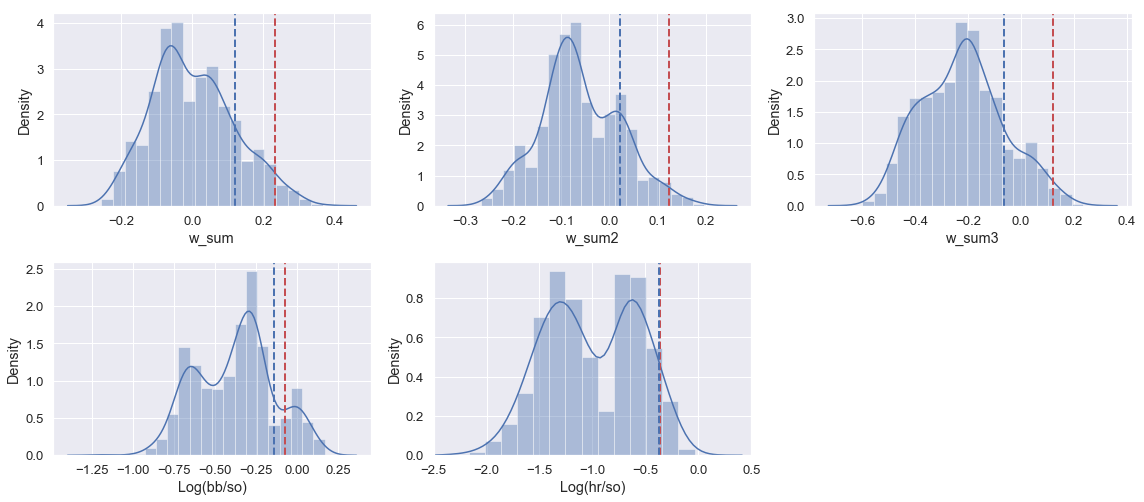

In [22]:
plt.figure(figsize=(16,10))
for i, stat in enumerate(['w_sum', 'w_sum2', 'w_sum3', 'bb/so', 'hr/so']):
    plt.subplot(3,3,i+1)
    if i > 2:
        sns.distplot(np.log10(df_player[stat] + 0.0001))
        plt.xlabel('Log('+ stat + ')')
    else:
        sns.distplot(df_player[stat])
        plt.xlabel(stat)
    plt.axvline(x=min_stats[i], color='r', linewidth=2, linestyle='--')
    plt.axvline(x=X[i] + sigma[i], color='b', linewidth=2, linestyle='--')
    plt.ylabel('Density')
plt.xlim([-2.5, 0.5])   
plt.tight_layout()
plt.show()

__Findings:__  In the figure above, the red dashed line represents the lowest stat amongst the 15 players, and the blue dashed lined represents 1 standard deviation above the mean. We can see that all top 15 players are outside 1 standard deviation. Therefore, __I am confident that the players I selected are all better than 68% of observations for EACH metric used above, based on the data I've received.__  

<a id="summarize"></a>
## Summarize results
Let's see where the `top15` are in our 3D plot!

In [23]:
df_player['Top_15'] = df_player.index.isin(top15.index)

In [24]:
group1 = df_player[df_player['Top_15'] == 1]
group2 = df_player[df_player['Top_15'] == 0]

p3 = Interactive3dPlot()
p3.create_trace_layer(group1['bb/pa'], group1['so/pa'], group1['hr/pa'], 'green', group1.index)
p3.create_trace_layer(group2['bb/pa'], group2['so/pa'], group2['hr/pa'], 'linen', group2.index)
p3.plot()

C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



__Findings:__ Looks pretty darn close to what we originally expected! Hooray!

Let's look at the cross sections.

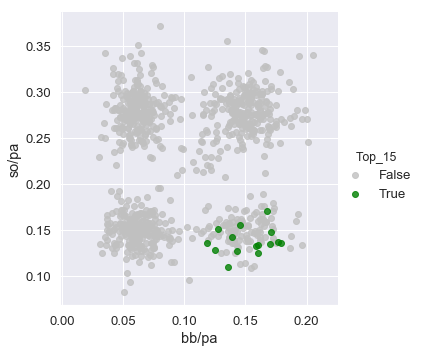

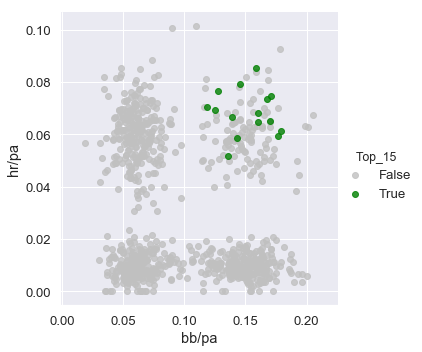

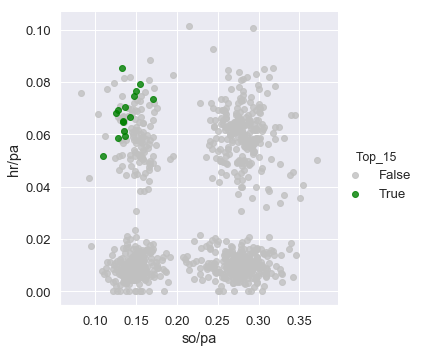

In [25]:
palette = ['silver', 'green']
sns.lmplot(x='bb/pa', y='so/pa', hue='Top_15', fit_reg=False, data=df_player, palette=palette)
sns.lmplot(x='bb/pa', y='hr/pa', hue='Top_15', fit_reg=False, data=df_player, palette=palette)
sns.lmplot(x='so/pa', y='hr/pa', hue='Top_15', fit_reg=False, data=df_player, palette=palette)
plt.show()

<a id="simulate"></a>
## Just for fun! (monte carlo simulation)
I did this next part just for fun. The code is pretty inefficient and I should probably put these into a class, but it gets the job done...

Here I simulate `w_sum` for two players: the top player and the median player. It's assumed the players get 400 `pa` for each season, and I simulate 1000 seasons each.

In [26]:
def get_stats(player):
    """Return average """
    return df_player.loc[player,['hr/pa', 'bb/pa', 'so/pa']].values

def create_intervals(mean_hr, mean_bb, mean_so):
    hr_thres = mean_hr*100
    bb_thres = hr_thres + mean_bb*100
    so_thres = bb_thres + mean_so*100
    return [hr_thres, bb_thres, so_thres]

def plate_appearance(threshold):
    rand = randint(0,100)
    if rand <= threshold[0]:
        return "hr"
    elif rand <= threshold[1]:
        return "bb"
    elif rand <= threshold[2]:
        return "so"
    return "other"

def simulate(player, num_pa):
    count_hr = 0
    count_bb = 0
    count_so = 0
    stats = get_stats(player)
    thresholds = create_intervals(stats[0], stats[1], stats[2])
    for i in range(num_pa):
        result = plate_appearance(thresholds)
        if result == "hr":
            count_hr += 1
        elif result == 'bb':
            count_bb += 1
        elif result == 'so':
            count_so += 1
    return [count_hr, count_bb, count_so]

def compute_stats(stats):
    scores = []
    for season in stats:
        scores.append((4*season[0] + season[1] - season[2]) / 400)
    return scores
        
best_player, median_player = [], []
for i in range(1000):
    best_player.append(simulate('ebd6d2f5d60ff9afaeda1a81fc53e2d0', 400))
    median_player.append(simulate('afdec7005cc9f14302cd0474fd0f3c96', 400))

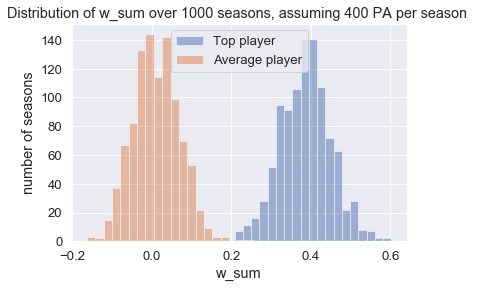

In [27]:
plt.hist(compute_stats(best_player), bins=20, alpha=0.5, label="Top player")
plt.hist(compute_stats(median_player), bins=20, alpha=0.5, label="Average player")
plt.legend()
plt.title("Distribution of w_sum over 1000 seasons, assuming 400 PA per season ")
plt.ylabel("number of seasons")
plt.xlabel("w_sum")
plt.show()